# Multi-Person 2D Pose Estimation using Part Affinity Fields
* Author: Johannes Maucher
* Last update: 14.06.2018

Pose Estimation requires to detect, localize and track the major parts/joints of the body, e.g. shoulders, ankle, knee, wrist etc.
* References:
    * [Chao et al; Realtime Multi-Person 2D Pose Estimation using Part Affinty Fields](https://arxiv.org/pdf/1611.08050.pdf). This paper defines the theory of the approach, implemented in this notebook. All images in this notebook are from this paper.
    * [Video from the authors](https://youtu.be/pW6nZXeWlGM)
    * [https://www.learnopencv.com/deep-learning-based-human-pose-estimation-using-opencv-cpp-python/](https://www.learnopencv.com/deep-learning-based-human-pose-estimation-using-opencv-cpp-python/)

* Datasets:
    * [Coco Keypoint Challenge](http://cocodataset.org/#keypoints-2018)
    * [MPII Human Pose Dataset](http://human-pose.mpi-inf.mpg.de/)
    * [VGG Pose Dataset](http://www.robots.ox.ac.uk/~vgg/data/pose_evaluation/)

* Pretrained Caffe models:
    * [Pretrained Caffe model for MPII](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel)
    * [Pretrained Caffe model for COCO](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel)


In [1]:
#!pip install opencv-python==3.4.13.47

In [2]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(cv2.__version__)

3.4.13


## Multiperson Pose Estimation

<img src="https://maucher.home.hdm-stuttgart.de/Pics/multiposeEstimation.png" style="width:600px" align="center">

### Approaches for Multi-Person Pose Estimation
#### Top-Down
* Person Detection
* Single Person Pose Estimation

#### Bottom-Up
* Detect keypoints (joints) in the image
* Connect joints to single person pose-models


## Theory
In this notebook a bottom-up approach, which applies deep neural netorks is implemented. The approach has been developed in [Chao et al; Realtime Multi-Person 2D Pose Estimation using Part Affinty Fields](https://arxiv.org/pdf/1611.08050.pdf). All images in this notebook are from this paper.

### Overall Pipeline
1. Pass entire image to CNN 
2. CNN predicts in multiple stages increasingly accurate 
    * **confidence maps** for body part candidates
    * **part affinity fields** for parts-associations
3. Perform bipartite matching to find candidates of body-part associations
4. Assemble parts and associations to full body poses

<img src="https://maucher.home.hdm-stuttgart.de/Pics/poseOverall.png" style="width:600px" align="center">

### Confidence Maps and Part Affinitiy Fields
* Set of $J$ Confidence Maps: 

$$
S=\lbrace S_1,S_2,\ldots,S_J \rbrace,$$ one for each body-part.
* Set of $C$ Part Affinity Fields: 

$$
L=\lbrace L_1,L_2,\ldots,L_C \rbrace,
$$ 

one per limb.
* Both have the same size $w  \times h$ as the image at the input

### CNN Architecture
* Stage 0: First 10 layers of VGG16, pretrained and fine tuned $\Rightarrow$ Feature Extraction
* Stage 1:
* Stage t ($t\geq2$): 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/poseArchitecture.png" style="width:500px" align="center">

* In each stage the simultaneous prediction of Confidence Maps and Part Affinity Fields is refined.
* The multi-stage approach mitigates the vanishing gradient problem
* Input to the first branch are the features F, extracted from the first 10 layers of VGG16
* In each subsequent stage, the predictions from both branches in the previous stage, along with the original image features F, are concatenated and used to produce refined predictions
* An L2 loss between the estimated predictions and the groundtruth maps and fields is applied in each stage.

### Loss at each stage
* Loss function for Confidence Map at stage t

$$ 
f_S^t= \sum\limits_{j=1}^J \sum_{\mathbf{b}} W(\mathbf{p}) \cdot \mid \mid S_j^t(\mathbf{p})-S_j^*(\mathbf{p})\mid\mid ^2)
$$

* Loss function for Part Affinity Field at stage t

$$ 
f_L^t= \sum\limits_{c=1}^C \sum_{\mathbf{b}} W(\mathbf{p}) \cdot \mid \mid L_c^t(\mathbf{p})-L_c^*(\mathbf{p})\mid\mid ^2)
$$

$S_j^*$ and $L_c^*$ are the groundtruths. $W$ is a binary mask with $W(\mathbf{p})=0$ if annotation is missing at an image location $\mathbf{p}$.

### Overall Loss
* The overall loss function is

$$
f=\sum\limits_{t=1}^T (f_S^t+f_L^t)
$$

* Stochastic Gradient Descent is applied to minimize the overall loss during training

### Groundtrouth for Confidence Maps
* Put Gaussian peaks over ground truth locations $\mathbf{x_{j,k}}$ of each body part $j$. Value at location $\mathbf{p}$ for the $k.th$ person in $S_{j,k}^*$: 

$$
S_{j,k}^*(\mathbf{p}) = \exp \left( - \frac{\mid \mid \mathbf{p} - \mathbf{x_{j,k}} \mid \mid ^2}{\sigma^2} \right).
$$

* Gaussian peaks of multiple persons in one map may overlap at location $\mathbf{p}$
* They are combined by

$$
S_j^*(\mathbf{p}) = \max_k S_{j,k}^*(\mathbf{p})
$$


### Groundtruth for Part Affinity Fields
* $\mathbf{x_{j_1,k}}$ and $\mathbf{x_{j_2,k}}$ are the groundtruth-positions of bodyparts $j_1$ and $j_2$ from limb $c$ of person $k$.
* $L_{c,k}^*(\mathbf{p})$ is a unit vector

$$
\mathbf{v}=\frac{(\mathbf{x_{j_2,k}}-\mathbf{x_{j_1,k}})}{\mid \mid \mathbf{x_{j_2,k}}-\mathbf{x_{j_1,k}}\mid \mid},
$$

that points from one bodypart to the other, if $\mathbf{p}$ lies on the limb, otherwise it is 0.
* $\mathbf{p}$ is said to *lie on the limb* if

$$
0 \leq (\mathbf{p}-\mathbf{x_{j_1,k}}) \cdot \mathbf{v}\leq l_{c,k} $$

and

$$
0 \leq (\mathbf{p}-\mathbf{x_{j_1,k}}) \cdot \mathbf{v_{\perp}}\leq \sigma_l ,
$$

where $\sigma_l$ is the limb width and $l_{c,k}=\mid \mid \mathbf{x_{j_1,k}}-\mathbf{x_{j_2,k}}\mid \mid$.

### Groundtruth for Part Affinity Fields
<img src="https://maucher.home.hdm-stuttgart.de/Pics/poseArm.png" style="width:500px" align="center">

* Since the PAFs of multiple persons may overlap, they are combined by

$$
L_c^*(\mathbf{p}) = \frac{1}{n_c(\mathbf{p})} \sum \limits_k L_{c,k}^*(\mathbf{p})
$$

### Infer limbs from part candidates
* Non-maximum suppression is applied on the detected confidence maps to obtain a set of discrete part candidate locations
* For each part there may be several candidates, due to
    * false positive detections
    * multiple persons in the image
* Set of part candidate locations defines a large set of possible limbs, among which the true limbs must be detected.
* For this the **association between part candidates** is measured as described in the following slide. 

### Measure Association between candidate part detections
* During **testing** association between candidate part detections is measured

$$
E=\int_{u=0}^{u=1} L_c(\mathbf{p}(u)) \cdot  \frac{(\mathbf{d_{j_2,k}}-\mathbf{d_{j_1,k}})}{\mid \mid \mathbf{d_{j_2,k}}-\mathbf{d_{j_1,k}}\mid \mid} du , 
$$

where $\mathbf{p}(u)$ interpolates the position between the two bodypart-locations $\mathbf{d_{j_1,k}}$ and $\mathbf{d_{j_2,k}}$:

$$
\mathbf{p}(u)=(1-u)\mathbf{d_{j_1,k}} + u \mathbf{d_{j_2,k}}
$$

* $L_c$ is the predicted PAF for limb $c$ and $\mathbf{d_{j_1,k}}$ and $\mathbf{d_{j_2,k}}$ are predicted part posistions (candidates for being part of limb $c$).

### Optimisation problem
* Set of body-part detection candidates:

$$ D_J = \lbrace \mathbf{d}_j^m : \mbox{ for } j \in \lbrace 1 \ldots J \rbrace,  m \in \lbrace 1 \ldots N_j \rbrace \rbrace,
$$

where 
    * $N_j$: number of candidates of part $j$
    * $\mathbf{d}_j^m$: location of $m.th$ detection candidate for part $j$
    
* Connection indicator

$$
z_{j_1j_2}^{mn} \in \lbrace 0,1 \rbrace,
$$

with $z_{j_1j_2}^{mn}=1$, if detection candidates $\mathbf{d}_{j_1}^m$ and $\mathbf{d}_{j_2}^n$ are connected.

* **Goal** ist to find the optimal assignment for the set of all possible connections

$$
Z=\lbrace z_{j_1j_2}^{mn} : \mbox{ for } j_1,j_2 \in \lbrace 1 \ldots J \rbrace,  m \in \lbrace 1 \ldots N_{j_1} \rbrace, n \in \lbrace 1 \ldots N_{j_2} \rbrace \rbrace,
$$


* For a pair of parts $j_1$ and $j_2$ the optimsation problem can be considered as an **maximum weight matching problem in a bipartite Graph**
* A matching in a bipartite graph is a subset of the edges chosen in such a way that no two edges share a node. Our goal is to find a matching with maximum weight for the chosen edges

$$
\max_{Z_c} E_c = \max_{Z_c} \sum\limits_{m \in D_{j_1}} \sum\limits_{n \in D_{j_2}} E_{mn} \cdot z_{j_1j_2}^{mn},
$$

such that

* $\forall m \in D_{j_1}: \sum\limits_{n \in D_{j_2}} z_{j_1j_2}^{mn} \leq 1$ and

* $\forall n \in D_{j_2}: \sum\limits_{m \in D_{j_1}} z_{j_1j_2}^{mn} \leq 1$

### Maximum Weight Matching in Bipartite-Graph  
<img src="https://maucher.home.hdm-stuttgart.de/Pics/poseBipartite.png" style="width:500px" align="center">

## Implementation

The authors of [Chao et al; Realtime Multi-Person 2D Pose Estimation using Part Affinty Fields](https://arxiv.org/pdf/1611.08050.pdf) provide a pretrained model for the pose-estimation approach, which has been descriped in the *Theory* part of this notebook. This pretrained model will be applied in the following code-cells.

### Specify the model to be used
* COCO and MPI are body pose estimation models. COCO has 18 points and MPI has 15 points as output.
* HAND is hand keypoints estimation model. It has 22 points as output.




The provided models have been trained with the Caffe Deep Learning Framework. Caffe models are specified by 2 files: 

* the *.prototxt* file specifies the architecture of the neural network
* the *.caffemodel* file stores the weights of the trained model

The *.prototxt*-files can be downloaded from:
* [https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/models](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/models)

The *.caffemodel* files can be downloaded from:
* [Pretrained Caffe model for MPII](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel)
* [Pretrained Caffe model for COCO](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel)


In [4]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "./pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "./pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "/Users/johannes/DataSets/pose/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "/Users/johannes/DataSets/pose/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-a10dad32cb4c>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if MODE is "COCO":
<ipython-input-4-a10dad32cb4c>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif MODE is "MPI" :


**COCO Output Format:**

Nose – 0, Neck – 1, Right Shoulder – 2, Right Elbow – 3, Right Wrist – 4,
Left Shoulder – 5, Left Elbow – 6, Left Wrist – 7, Right Hip – 8,
Right Knee – 9, Right Ankle – 10, Left Hip – 11, Left Knee – 12,
LAnkle – 13, Right Eye – 14, Left Eye – 15, Right Ear – 16,
Left Ear – 17, Background – 18

**MPII Output Format:**

Head – 0, Neck – 1, Right Shoulder – 2, Right Elbow – 3, Right Wrist – 4,
Left Shoulder – 5, Left Elbow – 6, Left Wrist – 7, Right Hip – 8,
Right Knee – 9, Right Ankle – 10, Left Hip – 11, Left Knee – 12,
Left Ankle – 13, Chest – 14, Background – 15

### Load image

In [5]:
image1 = cv2.imread("multiple.jpeg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

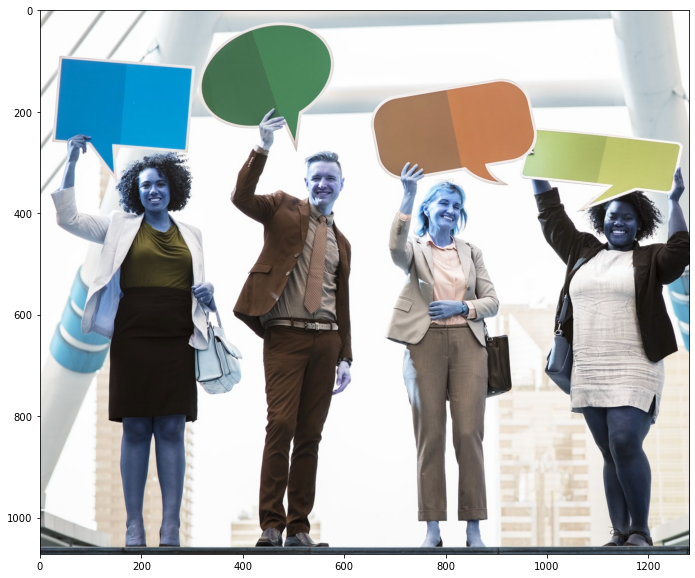

In [6]:
plt.figure(figsize=(12,10))
plt.imshow(image1)
plt.show()

### Load pretrained network

In [7]:
print(protoFile)
print(weightsFile)

/Users/johannes/DataSets/pose/pose_deploy_linevec_faster_4_stages.prototxt
/Users/johannes/DataSets/pose/pose_iter_160000.caffemodel


In [8]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

### Transform image to Caffe blob
The image must be converted into a *Caffe blob format*. This is done using the `blobFromImage()`-function. The parameters are 
* the image that shall be converted
* The operation to transform each pixel into a float between 0 and 1.
* the dimensions of the image 
* the Mean value to be subtracted (here: (0,0,0)). 
* a boolean which defines whether R and B channels shall be swapped. Here, there is no need to swapping, because both OpenCV and Caffe use BGR format.

In [9]:
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

### Pass input blob through the network

In [10]:
net.setInput(inpBlob)
output = net.forward()

The network's output contains the following elements:
* first dimension: image ID - this is relevant in the case that multiple images are passed to the network.
* second dimension: index of a keypoint. The model produces Confidence Maps and Part Affinity maps which are all concatenated. For COCO model it consists of 57 elements – 18 keypoint confidence Maps + 1 background + 19*2 Part Affinity Maps. Similarly, for MPI, it produces 44 points. 
* third dimension: height of the output map.
* fourth dimension: width of the output map.

In [11]:
print(output.shape)
np.set_printoptions(precision=4)
kp=5
print("Confidence map for keypoint {0:d}:".format(kp))
print(output[0, kp, :, :])
print("Maximum in confidence map: {0:1.3f}".
      format(np.max(output[0, kp, :, :])))

(1, 44, 46, 46)
Confidence map for keypoint 5:
[[0.0013 0.0013 0.0011 ... 0.0014 0.0014 0.0015]
 [0.0017 0.0014 0.0011 ... 0.0013 0.0013 0.0014]
 [0.0043 0.0024 0.0011 ... 0.0013 0.0013 0.0013]
 ...
 [0.0015 0.0014 0.0012 ... 0.0011 0.0023 0.0016]
 [0.0015 0.0014 0.0012 ... 0.0011 0.0021 0.0021]
 [0.0034 0.0013 0.0012 ... 0.0018 0.0023 0.0026]]
Maximum in confidence map: 0.833


### Plot confidence map of selected keypoint

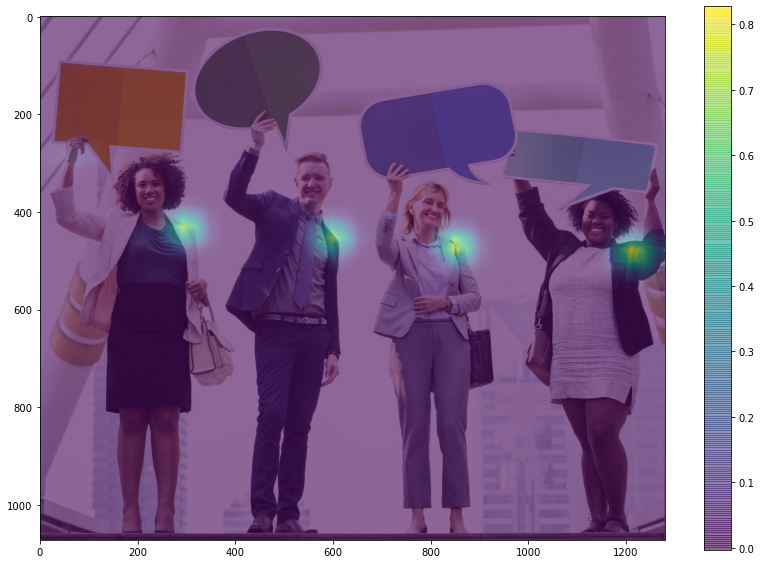

In [12]:
kp = 5
probMap = output[0, kp, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
#plt.axis("off")

### Plot affinity map on the image

(-0.5, 1279.5, 1071.5, -0.5)

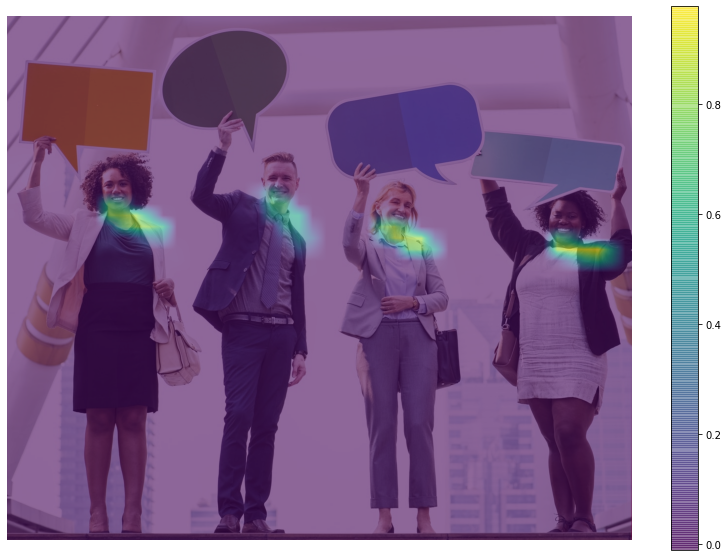

In [13]:
i = 24
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

### Keypoints of image with only single person

In [14]:
frame = cv2.imread("single.jpeg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

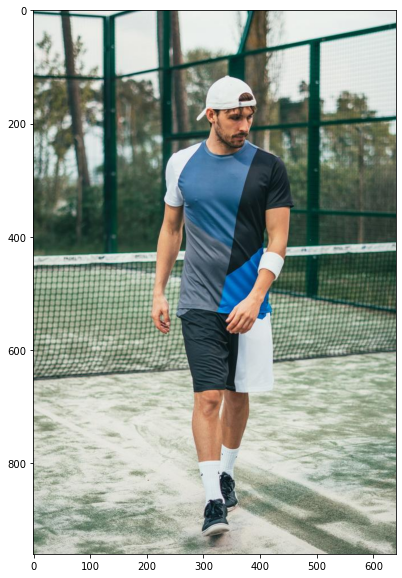

In [15]:
plt.figure(figsize=(12,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

#### Pass image-blob to network

In [16]:
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

#### Determine detected part locations
The location of each detected keypoint can be obtained by  determining the maxima of the keypoint's confidence map. A threshold is applied to reduce false positive detections. In order to plot the keypoint in the image, it's location in the output-map must be transformed to the corresponding image location.

In [17]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(probMap)
    
    prob=maxVal
    point=maxLoc
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

From the detected keypoints and the knowledge of which keypoint maps to which bodypart the skeleton can be drawn. For this the elements of the variable `pairs` are applied. These elements define which keypoint-pairs define a limb.

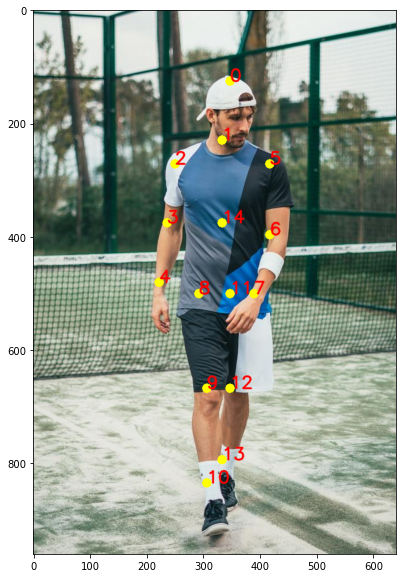

In [18]:
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.show()

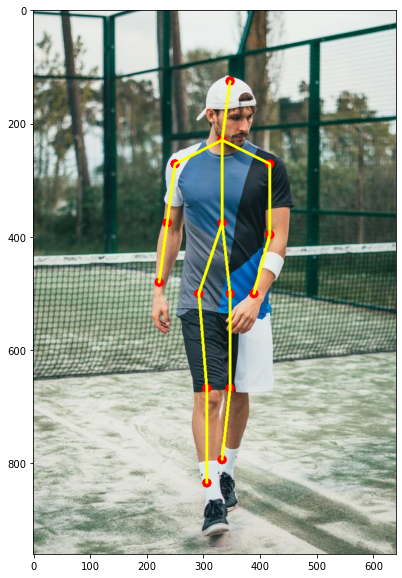

In [19]:
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)


plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()